# Notebook for solving the movement of water through unsaturated Porous Medium
## Belowground solver of soil moisture state
## Part of CLiMA land surface model component


In [2]:
# Set The PATH Here!
#push!(LOAD_PATH, "/Users/ddutta/Dropbox/JULIA_Research/Soil_Moisture_Codes/PREDICTOR_CORRECTOR/RichardsEquation/")
#push!(LOAD_PATH, "/Users/debsunderdutta/Dropbox/JULIA_Research/Soil_Moisture_Codes/PREDICTOR_CORRECTOR/RichardsEquation/")

#push!(LOAD_PATH,".")
push!(LOAD_PATH,"/Users/pierregentine/Dropbox/CliMa/Code/LSM-SPAM/src/Soil/")
# Include required libraries
#include("soil_moisture_V5.jl")
using Plots
using Parameters
using Printf
using soil_moisture_V5
using LaTeXStrings

┌ Info: Precompiling soil_moisture_V5 [top-level]
└ @ Base loading.jl:1242


# Richard's Equation Solver
$$
\frac{\partial \theta}{\partial t}=\frac{\partial}{\partial z}\left[K(\theta) \frac{\partial \psi}{\partial z}\right]+\frac{\partial K}{\partial z}
$$

We will solve the head based form here:
$$
C(\psi) \frac{\partial \psi}{\partial t}=\frac{\partial}{\partial z}\left[K(\theta) \frac{\partial \psi}{\partial z}\right]+\frac{\partial K}{\partial z}
$$
For the solution we use a Finite Difference Scheme and more specifically an implicit time discretization is used where the spatial derivatives are written using a central difference scheme at time n+1 and a backward time difference approximation at time n+1.
The computational grid is as follows:
<img src="Compute_grid.png" style="width:400px;"/>
The finite difference approximation of the $\psi$ based form is as follows:
$$
\begin{array}{l}{-\frac{K_{i-1 / 2}^{n+1}}{\Delta z_{i-1 / 2}} \psi_{i-1}^{n+1}+\left(\frac{C_{i}^{n+1} \Delta z_{i}}{\Delta t}+\frac{K_{i-1 / 2}^{n+1}}{\Delta z_{i-1 / 2}}+\frac{K_{i+1 / 2}^{n+1}}{\Delta z_{i+1 / 2}}\right) \psi_{i}^{n+1}} \\ {-\frac{K_{i+1 / 2}^{n+1}}{\Delta z_{i+1 / 2}} \psi_{i+1}^{n+1}=\frac{C_{i}^{n+1} \Delta z_{i}}{\Delta t} \psi_{i}^{n}+K_{i-1 / 2}^{n+1}-K_{i+1 / 2}^{n+1}}\end{array}
$$

Boundary Conditions:
we specify $\psi_0$ at the top     (Dirichlet Boundary)

Free Drainage at bottom $Q_N=-K_N$ (Neumann Boundary)
Pierre: I would not suggest a free drainage - we won't be able to get a correct water table - need to refine this

Numerical Method used: Predictor Corrector - solves Richards equation twice. The predictor step is used to solve for $\psi$ over $(\Delta t/2)$ using K and C from time n, the Corrector step uses these to obtain $\psi$ over the full time step n.
The general form of the tridiagonal system of equations is:

$$
a_{i} \psi_{i-1}^{n+1}+b_{i} \psi_{i}^{n+1}+c_{i} \psi_{i+1}^{n+1}=d_{i}
$$

$$
\left[\begin{array}{cccccc}{b_{1}} & {c_{1}} & {0} & {0} & {0} & {0} \\ {a_{2}} & {b_{2}} & {c_{2}} & {0} & {0} & {0} \\ {0} & {a_{3}} & {b_{3}} & {c_{3}} & {0} & {0} \\ {0} & {0} & {\ddots} & {\ddots} & {\ddots} & {0} \\ {0} & {0} & {0} & {a_{N-1}} & {b_{N-1}} & {c_{N-1}} \\ {0} & {0} & {0} & {0} & {a_{N}} & {b_{N}}\end{array}\right] \times\left[\begin{array}{c}{\psi_{1}^{n+1}} \\ {\psi_{2}^{n+1}} \\ {\psi_{3}^{n+1}} \\ {\vdots} \\ {\psi_{N-1}^{n+1}} \\ {\psi_{N}^{n+1}}\end{array}\right]=\left[\begin{array}{c}{d_{1}} \\ {d_{2}} \\ {d_{3}} \\ {\vdots} \\ {d_{N-1}} \\ {d_{N}}\end{array}\right]
$$

In [5]:
# ---------------------------------------------------------------------
# Use the predictor-corrector method to solve the Richards equation for
# infiltration with surface soil moisture as the boundary condition.
# ---------------------------------------------------------------------
zsoil_total = 1000
nsoi        = 100
global soil = soil_moisture_V5.soil_struct(nsoi=150, zsoil=zsoil_total, functions = "van_Genuchten",
              sand=50*ones(nsoi), clay=30*ones(nsoi), Ts = 301*ones(nsoi), theta = 0.2 , psi = zeros(nsoi)) # Define the number of soil Layers

# Generate the Soil Compute Grid
soil = soil_moisture_V5.compute_grid_settings(soil)

# --- Soil parameters Settings
soil.ssflag    = 0 # Flag for Sink term
soil.functions = "van_Genuchten";  # Use van Genuchten relationships
#soil.functions = "Campbell";       # Use Campbell relationships

if soil.functions == "Campbell"

   # example from Hornberger & Wiberg [2005, Fig. 8.3]
   ityp = 0;              # Soil texture flag
   theta_sat = 0.25;      # Volumetric water content at saturation
   psi_sat = -25.0;       # Matric potential at saturation [cm]
   bc = 0.2;              # Exponent
   Ksat = 3.4e-03;        # Hydraulic conductivity at saturation [cm/s]
   params = [theta_sat psi_sat bc Ksat ityp]

elseif soil.functions == "van_Genuchten"

   # Haverkamp et al. (1977): sand
   ityp = 1;              # Soil texture flag
   theta_res = 0.075;     # Residual water content
   theta_sat = 0.287;     # Volumetric water content at saturation
   vg_alpha = 0.027;      # Inverse of the air entry potential [/cm]
   vg_n = 3.96;           # Pore-size distribution index
   vg_m = 1;              # Exponent
   Ksat = 34 / 3600;      # Hydraulic conductivity at saturation [cm/s]

#  # Haverkamp et al. (1977): Yolo light clay
#  ityp = 2;              # Soil texture flag
#  theta_res = 0.124;     # Residual water content
#  theta_sat = 0.495;     # Volumetric water content at saturation
#  vg_alpha = 0.026;      # Inverse of the air entry potential [/cm]
#  vg_n = 1.43;           # Pore-size distribution index
#  vg_m = 1 - 1 / vg_n;   # Exponent
#  Ksat = 0.0443 / 3600;  # Hydraulic conductivity at saturation [cm/s]

   params = [theta_res theta_sat vg_alpha vg_n vg_m Ksat ityp]
end

# --- Initial soil moisture & matric potential
for i = 1:soil.nsoi
    @printf("z[i] = %8.3f \n",soil.z[i])
    soil.theta[i] = maximum([minimum([(soil.z[i]/zsoil_total)*(theta_sat-theta_res)+theta_res,theta_sat-1e-2]),theta_res])
    soil.psi[i]   = matric_potential(soil.functions, params, soil.theta[i])
    soil.Ts[i]    = 20. + 273.15
end

global thetaini = copy(soil.theta)

# --- Surface boundary condition: saturation [minus some small delta]
soil.intialize(soil)

soil.theta = theta_sat - 1.0e-03
soil.psi0 = matric_potential(soil.functions, params, soil.theta0)

# --- Time step [seconds]

dt = 10
if (ityp == 1)
   dt = 5
end

# --- Length of simulation [number of time steps]

# Hornberger & Wiberg: 15; 30; | 60 minutes
if (ityp == 0)
#  ntim = 15 * 60 / dt
#  ntim = 30 * 60 / dt
   ntim = 60 * 60 / dt
end

# Haverkamp et al. (1977) - sand: duration is in hours
if (ityp == 1)
#  ntim = 0.05 * 3600 / dt
#  ntim = 0.1 * 3600 / dt
#  ntim = 0.2 * 3600 / dt
#  ntim = 0.3 * 3600 / dt
# ntim = 0.4 * 3600 / dt
  ntim = 0.8 * 3600 / dt
end

# Haverkamp et al. (1977) - Yolo light clay: duration is in seconds
if (ityp == 2)
#  ntim = 1.0e4 / dt
#  ntim = 1.0e5 / dt
#  ntim = 5.0e5 / dt
   ntim = 1.0e6 / dt
end


# --- Initialize accumulators for water balance check
global sum_in    = 0
global sum_out   = 0
global sum_store = 0

global ET = 0.006

# --- Time stepping loop: NTIM iterations with a time step of DT seconds
# Initialize cumulative infiltration variables
xout = zeros(Int64.(ntim))
yout = zeros(Int64.(ntim))
for itim = 1:Int64.(ntim)

   # Hour of day

   hour = itim * (dt/86400 * 24)
   @printf("hour = %8.3f \n",hour)
    
#  # Add for fun variable Boundary Condition SURFACE DRYING
#     if itim > 100
#         soil.theta0 = theta_sat - 1.0e-03
#         if (ityp == 1)
#            soil.theta0 = 0.267 - (itim-200)*0.1/ntim
#         end
#         soil.psi0 = matric_potential(soil.functions, params, soil.theta0)
#     end


   # Calculate soil moisture adn tempoerature tendencies - ike in claimte model - apply one tendency at a time
   soil = predictor_corrector_moisture(soil, params, ET, dt)
   soil = predictor_corrector_temperature(soil, params, ET, dt)


   # Sum fluxes for relative mass balance error()

   sum_in = sum_in + abs(soil.Q0) * dt
   sum_out = sum_out + abs(soil.QN) * dt
   sum_store = sum_store + soil.dtheta
    if itim%10 == 0
        IJulia.clear_output(true)
        Plots.display(plot(soil.theta,soil.z, color="red",line=2,xlabel = "theta [-]",ylabel = "z [cm]",title="Time = "*string(round(hour*60,digits=2))*" mins"))
        sleep(0.2)
    end
        
    #print(soil.sink)

   # cumulative infiltration
   xout[itim] = hour
   yout[itim] = sum_in

end

UndefVarError: UndefVarError: theta_sat not defined

infiltration [cm] =    1.303 
drainage [cm] =    2.386 
storage [cm] =    1.184 
mass balance error (percent) =  209.267 


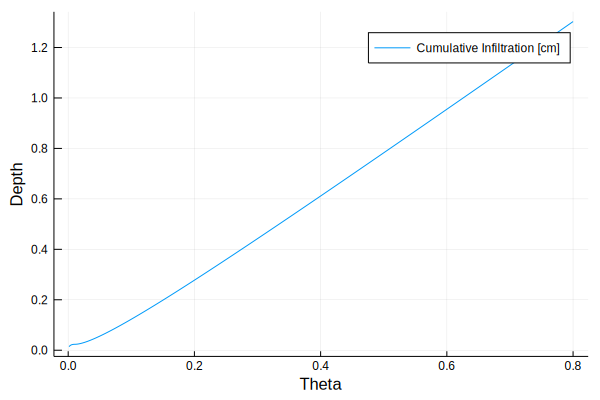

In [11]:
# Printing And Plotting
# --- Print mass balance()

@printf("infiltration [cm] = %8.3f \n",sum_in)
@printf("drainage [cm] = %8.3f \n",sum_out)
@printf("storage [cm] = %8.3f \n",sum_store)
relerr = ((sum_in - sum_out) - sum_store) / (sum_in - sum_out) * 100.0
@printf("mass balance error (percent) = %8.3f \n",relerr)

# Plot Cumulative Infiltration

plot(xout,yout,label="Cumulative Infiltration [cm]",xlabel="Theta",ylabel="Depth")


## Richards Equation with Sink Term
### This term accounts for Root uptake (extraction)

The head based form of the equation can be represented as:
$$
C(\psi) \frac{\partial \psi}{\partial t}=\frac{\partial}{\partial z}\left[K(\theta) \frac{\partial \psi}{\partial z}\right]+\frac{\partial K}{\partial z} - S_{w,i}
$$

Bonan's suggestion, partition the ET as per the following relationships.
$$
S_{w, i}=E\left(\Delta F_{i} \beta_{w, i} / \sum_{i=1}^{N} \Delta F_{i} \beta_{w, i}\right)
$$
which involves the root fraction and a soil wetness factor
$$
F(z)=1-\beta^{100 z}
$$

$$
\beta_{w, i}=\left\{\begin{array}{ll}{\frac{\psi_{i}-\psi_{d r y}}{\psi_{o p t}-\psi_{d r y}}} & {\psi_{i}>\psi_{d r y}} \\ {0} & {\psi_{i} \leq \psi_{d r y}}\end{array}\right.
$$



In [4]:
# ---------------------------------------------------------------------
# Use the predictor-corrector method to solve the Richards equation for
# infiltration with surface soil moisture as the boundary condition.
# ---------------------------------------------------------------------

global soil = soil_moisture_V4.soil_struct(nsoi=150) # Define the number of soil Layers

# Generate the Soil Compute Grid
soil = soil_moisture_V4.compute_grid_settings(soil)
soil.ssflag = 1 # Flag to compute the sink terms
root_frac   = 1 # Flag for the root fraction 1-Normal, 2-All at top funny, 3-Ridiculous

# Specify the ET
global ET = 0.005 # units are [cm/sec]
ET_flag   = 0     # 0 for constant ET 1 for a sinusoidal variation

# Some arbitrary values for computing the wetness factor
soil.psidry = -100
soil.psiopt = -10

# Compute some root fraction
if root_frac == 1
    soil.bi=0.92
    soil.fz=soil.fz*0

    soil.fz[1] = soil.bi^abs(soil.z[1])
    for i = 2:soil.nsoi
        soil.z[i] = 0.5 * (soil.z_plus_onehalf[i-1] + soil.z_plus_onehalf[i])

        # Assign the root fraction here
        soil.fz[i] = soil.bi^abs(soil.z[i])# if z is in cm
        print(soil.fz[i])
    end
elseif root_frac == 2
    soil.fz=soil.fz*0
    # Some sinusoidal shape
    x=range(0,stop=2*pi,length=20)
    y=sin.(x)
    soil.fz[1:20]=abs.(y)
    
elseif root_frac == 3
    soil.fz=soil.fz*0
    # Some sinusoidal shape
    x=range(0,stop=2*pi,length=20)
    y=sin.(x)
    soil.fz[1:20]=abs.(y)
    soil.fz[51:70]=abs.(y)*0.5
end

# --- Soil parameters Settings

soil.functions = "van_Genuchten";  # Use van Genuchten relationships
#soil.functions = "Campbell";       # Use Campbell relationships

if soil.functions == "Campbell"

   # example from Hornberger & Wiberg [2005, Fig. 8.3]
   ityp = 0;              # Soil texture flag
   theta_sat = 0.25;      # Volumetric water content at saturation
   psi_sat = -25.0;       # Matric potential at saturation [cm]
   bc = 0.2;              # Exponent
   Ksat = 3.4e-03;        # Hydraulic conductivity at saturation [cm/s]
   params = [theta_sat psi_sat bc Ksat ityp]

elseif soil.functions == "van_Genuchten"

   # Haverkamp et al. (1977): sand
   ityp = 1;              # Soil texture flag
   theta_res = 0.075;     # Residual water content
   theta_sat = 0.287;     # Volumetric water content at saturation
   vg_alpha = 0.027;      # Inverse of the air entry potential [/cm]
   vg_n = 3.96;           # Pore-size distribution index
   vg_m = 1;              # Exponent
   Ksat = 34 / 3600;      # Hydraulic conductivity at saturation [cm/s]

#  # Haverkamp et al. (1977): Yolo light clay
#  ityp = 2;              # Soil texture flag
#  theta_res = 0.124;     # Residual water content
#  theta_sat = 0.495;     # Volumetric water content at saturation
#  vg_alpha = 0.026;      # Inverse of the air entry potential [/cm]
#  vg_n = 1.43;           # Pore-size distribution index
#  vg_m = 1 - 1 / vg_n;   # Exponent
#  Ksat = 0.0443 / 3600;  # Hydraulic conductivity at saturation [cm/s]

   params = [theta_res theta_sat vg_alpha vg_n vg_m Ksat ityp]
end


# --- Initial soil moisture & matric potential
print("ok")
for i = 1:soil.nsoi
   if (ityp == 0)
      soil.theta[i] = 0.10
   elseif ityp == 1
      soil.theta[i] = 0.10
   elseif ityp == 2
      soil.theta[i] = 0.24
   end
   soil.psi[i] = matric_potential(soil.functions, params, soil.theta[i])
end

# --- Surface boundary condition: saturation [minus some small delta]

soil.theta0 = theta_sat - 1.0e-03
if (ityp == 1)
   soil.theta0 = 0.267
end
soil.psi0 = matric_potential(soil.functions, params, soil.theta0)

# --- Time step [seconds]

dt = 10
if (ityp == 1)
   dt = 5
end

# --- Length of simulation [number of time steps]

# Hornberger & Wiberg: 15; 30; | 60 minutes
if (ityp == 0)
   ntim = 60 * 60 / dt
end

# Haverkamp et al. (1977) - sand: duration is in hours
if (ityp == 1)
  ntim = 0.8 * 3600 / dt
end

# Haverkamp et al. (1977) - Yolo light clay: duration is in seconds
if (ityp == 2)
   ntim = 1.0e6 / dt
end


# --- Initialize accumulators for water balance check
global sum_in = 0
global sum_out = 0
global sum_tr = 0
global sum_store = 0

global theta_store = soil.theta # Store all SM Profiles

# --- Time stepping loop: NTIM iterations with a time step of DT seconds
xout = zeros(Int64.(ntim))
yout = zeros(Int64.(ntim))

if ET_flag == 1
    x=range(0,stop=pi,length=Int64.(ntim))
    y=sin.(x)
    ET_vary = y*ET
end
for itim = 1:Int64.(ntim)

   # Hour of day

   hour = itim * (dt/86400 * 24)
   @printf("hour = %8.3f \n",hour)
    
 # Add for fun variable Boundary Condition SURFACE DRYING
    if itim > 100
        soil.theta0 = theta_sat - 1.0e-03
        if (ityp == 1)
           soil.theta0 = 0.267 - (itim-200)*0.05/ntim
        end
        soil.psi0 = matric_potential(soil.functions, params, soil.theta0)
    end

   # Calculate soil moisture
    if ET_flag == 1
        ET = ET_vary[itim]
    end
   soil = predictor_corrector(soil, params, ET, dt)


   # Sum fluxes for relative mass balance error()

   sum_in = sum_in + abs(soil.Q0) * dt
   sum_out = sum_out + abs(soil.QN) * dt
   sum_tr = sum_tr + sum(soil.sink) * dt
   sum_store = sum_store + soil.dtheta
    theta_store=hcat(theta_store,soil.theta)
    if itim%10 == 0
        IJulia.clear_output(true)
        Plots.display(plot(soil.theta,soil.z, xlim=(0,0.3), color="red",label="Soil Moisture",line=2,xlabel = "theta [-]",ylabel = "z [cm]",title="Time = "*string(round(hour*60,digits=2))*" mins"))
        sleep(0.1)
    end
        
    #print(soil.sink)

   # cumulative infiltration
   xout[itim] = hour
   yout[itim] = sum_in

end

if ET_flag == 1
    plot(ET_vary,color="Blue",line=2,xlabel = "Time",ylabel = "ET [cm/sec]")
end

ErrorException: Field 'zsoil' has no default, supply it with keyword.

In [5]:
##### Printing And Plotting
# --- Print mass balance()

@printf("infiltration [cm] = %8.3f \n",sum_in)
@printf("drainage [cm] = %8.3f \n",sum_out)
@printf("storage [cm] = %8.3f \n",sum_store)
@printf("transpiration [cm] = %8.3f \n",sum_tr)
relerr = ((sum_in - sum_out - sum_tr) - sum_store) / (sum_in - sum_out - sum_tr) * 100.0
@printf("mass balance error (percent) = %8.3f \n",relerr)

# --- Graph data

plot(soil.theta,soil.z,color="red",label="Soil Moisture",line=2,xlabel = "theta [-]/Root Frac",ylabel = "z [cm]",title="Final Time Step")
plot!(soil.fz,soil.z,color="blue",label="Root Fraction",line=2)

infiltration [cm] =   10.966 
drainage [cm] =    4.780 
storage [cm] =    8.492 


UndefVarError: UndefVarError: sum_tr not defined

In [6]:
using PyPlot
PyPlot.plt.figure(figsize=(10,5))
ax=PyPlot.pcolormesh(theta_store[end:-1:1,:],cmap="terrain") # nipy_spectral
PyPlot.plt.colorbar()
locs, labels = xticks()
locs[7] = ntim
xticks(locs,locs)
xlabel("Time (*dt [secs])")
locs, labels = yticks()
locs[9] = 150
locsy = locs.-150
yticks(locs,locsy)
ylabel("Soil Depth z [cm]")
print(locs)

ArgumentError: ArgumentError: Package PyPlot not found in current path:
- Run `import Pkg; Pkg.add("PyPlot")` to install the PyPlot package.


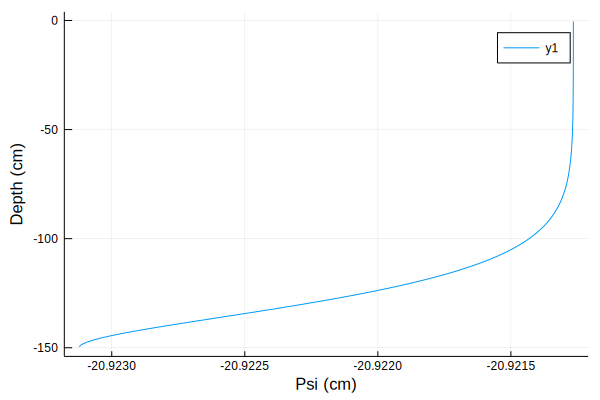

In [7]:
plot(xout,yout,label="Cumulative Plot",xlabel="Time",ylabel="Cumulative Infiltration")
plot(soil.psi,soil.z,xlabel="Psi (cm)",ylabel="Depth (cm)")